We need to activate the dropouts during testing for this purpose. Let's do that.

In [1]:
# import the necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import random
import shutil
from scipy import ndimage
# from joblib import Parallel, delayed
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr

In [2]:
# load trained model here
TN_model = tf.keras.models.load_model('models/TN_model_with_new_data.h5')
# look at the input shape
TN_model.input

<KerasTensor: shape=(None, 32, 32, 3) dtype=float32 (created by layer 'conv2d_input')>

In [3]:
TN_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                           

In [4]:
# Let's redefine the model
new_input = tf.keras.layers.Input(shape = (32,32,3))

# add a conv2d layer
new_conv2d_1 = tf.keras.layers.Conv2D(32, kernel_size = (3,3), padding = 'same')
new_conv2d_1_out = new_conv2d_1(new_input)
# add activation
new_act_1 = tf.keras.layers.Activation("relu")
new_act_1_out = new_act_1(new_conv2d_1_out)

# add a conv2d layer
new_conv2d_2 = tf.keras.layers.Conv2D(32, kernel_size = (3,3), padding = 'valid')
new_conv2d_2_out = new_conv2d_2(new_act_1_out)
# add activation
new_act_2 = tf.keras.layers.Activation("relu")
new_act_2_out = new_act_2(new_conv2d_2_out)

# add a maxpooling layer
max_pooling_1 = tf.keras.layers.MaxPool2D()
max_pooling_1_out = max_pooling_1(new_act_2_out)

# add a dropout layer
dropout_1 = tf.keras.layers.Dropout(0.25)
dropout_1_out = dropout_1(max_pooling_1_out, training = True)

# add a conv2d layer
new_conv2d_3 = tf.keras.layers.Conv2D(64, kernel_size = (3,3), padding = 'same')
new_conv2d_3_out = new_conv2d_3(dropout_1_out)
# add activation
new_act_3 = tf.keras.layers.Activation("relu")
new_act_3_out = new_act_3(new_conv2d_3_out)

# add a conv2d layer
new_conv2d_4 = tf.keras.layers.Conv2D(64, kernel_size = (3,3), padding = 'valid')
new_conv2d_4_out = new_conv2d_4(new_act_3_out)
# add activation
new_act_4 = tf.keras.layers.Activation("relu")
new_act_4_out = new_act_4(new_conv2d_4_out)

# add a maxpooling layer
max_pooling_2 = tf.keras.layers.MaxPool2D()
max_pooling_2_out = max_pooling_2(new_act_4_out)

# add a dropout layer
dropout_2 = tf.keras.layers.Dropout(0.25)
dropout_2_out = dropout_2(max_pooling_2_out, training = True)

# add a flatten layer
flat_layer = tf.keras.layers.Flatten()
flat_layer_out = flat_layer(dropout_2_out)

# add a dense layer
dense_1 = tf.keras.layers.Dense(512)
dense_1_out = dense_1(flat_layer_out)
# add activation
new_act_5 = tf.keras.layers.Activation("relu")
new_act_5_out = new_act_5(dense_1_out)
# add a dropout layer
dropout_3 = tf.keras.layers.Dropout(0.5)
dropout_3_out = dropout_3(new_act_5_out, training = True)

# add a dense layer - prediction head
dense_final = tf.keras.layers.Dense(1)
dense_final_out = dense_final(dropout_3_out)
# add activation
new_act_6 = tf.keras.layers.Activation("relu")
new_act_6_out = new_act_6(dense_final_out)

In [5]:
new_model = tf.keras.models.Model(inputs = new_input, outputs = new_act_6_out)
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                             

In [6]:
weights = TN_model.get_weights()

In [7]:
new_model.set_weights(weights)

In [8]:
weights_new = new_model.get_weights()

In [9]:
print(len(weights), len(weights_new))

12 12


In [10]:
for i in range(len(weights)):
    print(np.mean(weights[i] == weights_new[i]))

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


In [11]:
block_number = 'Block_13'
file_path  = 'Preprocessed_test_data/all_img_density_files/'
split_test_file_path = os.path.join(file_path, block_number)

In [12]:
split_test_images = [file for file in os.listdir(split_test_file_path) if file.split(".")[0][-3:] != 'map']
split_test_images.sort()

In [13]:
# split_test_images

In [14]:
len(split_test_images)

32

In [15]:
# check the shapes of the image files
counter = 0
for file in split_test_images:
    load_file = np.load(split_test_file_path + '/' + file)
    counter = counter + 1
    print(counter, file, load_file.shape)

1 Block0103_2020_06_29.npy (1024, 768, 3)
2 Block0103_2020_07_01.npy (1024, 768, 3)
3 Block0103_2020_07_02.npy (1024, 768, 3)
4 Block0103_2020_07_06.npy (1024, 768, 3)
5 Block0103_2020_07_07.npy (1024, 768, 3)
6 Block0103_2020_07_08.npy (1024, 768, 3)
7 Block0103_2020_07_14.npy (1024, 768, 3)
8 Block0103_2020_07_16.npy (1024, 768, 3)
9 Block0103_2020_07_17.npy (1024, 768, 3)
10 Block0103_2020_07_20.npy (1024, 768, 3)
11 Block0103_2020_07_22.npy (1024, 768, 3)
12 Block0103_2020_07_23.npy (1024, 768, 3)
13 Block0103_2020_08_03.npy (768, 1024, 3)
14 Block0103_2020_08_04.npy (768, 1024, 3)
15 Block0103_2020_08_06.npy (768, 1024, 3)
16 Block0103_2020_08_07.npy (768, 1024, 3)
17 Block0103_2020_08_11.npy (768, 1024, 3)
18 Block0103_2020_08_12.npy (768, 1024, 3)
19 Block0103_2020_08_14.npy (768, 1024, 3)
20 Block0103_2020_08_15.npy (768, 1024, 3)
21 Block0103_2020_08_17.npy (768, 1024, 3)
22 Block0103_2020_08_18.npy (768, 1024, 3)
23 Block0103_2020_08_19.npy (768, 1024, 3)
24 Block0103_2020_08

In [16]:
# get the stacked test sub windows path
block_number = 'Block_13'
stacked_test_file_path = os.path.join('final_test_sub_windows_and_counts/', block_number)
stacked_test_file_path

'final_test_sub_windows_and_counts/Block_13'

In [17]:
# get the contents
contents_stacked_test_path = os.listdir(stacked_test_file_path)
contents_stacked_test_path.sort()

In [18]:
# contents_stacked_test_path

In [19]:
# get only the image files
images_stacked_test = [file for file in contents_stacked_test_path if file[:8] == 'test_ims']
images_stacked_test.sort()

In [20]:
len(images_stacked_test)

32

In [21]:
images_stacked_test[0]

'test_ims_Block0103_2020_06_29.npy'

In [22]:
images_stacked_test[0].split('test_ims_')[-1]

'Block0103_2020_06_29.npy'

In [23]:
# define a function to get the post-hoc prediction
def prediction_on_test_data(model, numpy_folder, v_stack_folder, selected_file, stride = 8, kernel_size = 32):
#     load the cnn model
    
# load the image data file
    load_image = np.load(numpy_folder + "/"+ selected_file)
    
    # get the image height
    img_height = load_image.shape[0]
    # get the image weight
    img_width = load_image.shape[1]

    selected_stacked_file = 'test_ims_' + selected_file
    all_test_sub_windows = np.load(v_stack_folder + "/"+ selected_stacked_file)

    # now, to get the predictions, pass the sub windows
    test_image_prediction = model.predict(all_test_sub_windows)
    
    # density map
    Density_map = np.zeros((img_height, img_width))

    # counts map
    counts_map = np.zeros((img_height, img_width))
    
    # now, for every window, we will keep adding the values together and also add the counts
    counter = 0
#     need a counter to move into each predicted value in the pred values list
    for ii in range(0, img_height, stride):
        for jj in range(0, img_width, stride):
#         operations for density map
#             get the window of interest
            new_window = Density_map[ii:ii + kernel_size,jj:jj+kernel_size]
#     fill each with the value c_k
            counts_window = np.full((new_window.shape[0], new_window.shape[1]), test_image_prediction[counter])
#     get the shapes of this new window
            cw_height = counts_window.shape[0]
            cw_width = counts_window.shape[1]
#         Do c_k/r_2
            counts_window_new = counts_window/(cw_height*cw_width)
#     This is the value in the window now
            value_window = counts_window_new
#     place the values in the corrsponding area of the density map
            Density_map[ii:ii + kernel_size,jj:jj+kernel_size] = new_window + value_window

#         Let's now focus on capturing the counts of the windows
            new_window_c = counts_map[ii:ii + kernel_size,jj:jj+kernel_size]
#     get the counts area
            count = np.ones((new_window_c.shape[0], new_window_c.shape[1]))
#     keep adding the counts to reflect the addition of densities
            counts_map[ii:ii + kernel_size,jj:jj+kernel_size] = new_window_c + count
#     increase the counter
            counter = counter + 1
            
#         get the normalized count
    normalized_counts = np.divide(Density_map, counts_map)
    
#     entire count on the test set
    pred_on_test = np.sum(normalized_counts)
    
#     return the predicted value
    return(pred_on_test, normalized_counts, selected_file)

In [24]:
# get the preds for a single image

In [25]:
model = new_model
numpy_folder = split_test_file_path
v_stack_folder = stacked_test_file_path
selected_file = split_test_images[0]
stride = 8
kernel_size = 32

In [26]:
%%time
# get the predictions for test data

# save density map path
dense_path = "predicted_count_maps_for_test_files/Block_13"

final_values_preds_names = []
for file in split_test_images:
    name = file
    all_preicted_values = []
    # normalized_pred_maps = []
    for i in range(25):
        preds_value, norm_counts, _ = prediction_on_test_data(new_model, split_test_file_path, stacked_test_file_path, file, stride = 8, kernel_size = 32)
        # save the normalized density maps
        np.save(dense_path + '/' + file.split('.')[0] + '_' + str(i) + '_norm_map_TN.npy', norm_counts)
        all_preicted_values.append(preds_value)
        # normalized_pred_maps.append(norm_counts)
    final_values_preds_names.append((name, all_preicted_values))

CPU times: user 18min 41s, sys: 4min 8s, total: 22min 49s
Wall time: 22min 44s


In [27]:
preds_df = pd.DataFrame(final_values_preds_names, columns = ['image_name', 'predictions'])

In [28]:
preds_df = preds_df.join(preds_df['predictions'].apply(pd.Series))

In [29]:
preds_df = preds_df.drop(['predictions'], axis = 1)

In [30]:
preds_df.columns = ['name'] + ['predicted_count_' + str(i) for i in range(25)]

In [31]:
preds_df['name'] = [i.split(".")[0] for i in preds_df['name']]

In [32]:
preds_df.head()

,name,predicted_count_0,predicted_count_1,predicted_count_2,predicted_count_3,predicted_count_4,predicted_count_5,predicted_count_6,predicted_count_7,predicted_count_8,...,predicted_count_15,predicted_count_16,predicted_count_17,predicted_count_18,predicted_count_19,predicted_count_20,predicted_count_21,predicted_count_22,predicted_count_23,predicted_count_24
0,Block0103_2020_06_29,2.605250,2.845343,2.707392,2.752444,2.836012,2.801777,2.918109,2.651569,2.704982,...,2.858052,2.833017,2.923500,2.760462,3.015003,2.754672,2.874882,2.799495,2.707215,2.867252
1,Block0103_2020_07_01,2.315793,2.279669,2.518561,2.373566,2.390035,2.254934,2.270743,2.393959,2.511500,...,2.421461,2.322728,2.358328,2.341507,2.323515,2.308860,2.289656,2.439158,2.325113,2.405797
2,Block0103_2020_07_02,4.169767,4.085872,4.134363,3.995497,3.919755,3.989223,4.028149,4.206689,3.884274,...,4.184798,4.080666,4.151832,4.121983,4.012497,4.069461,4.181019,4.110959,4.256884,4.027033
3,Block0103_2020_07_06,8.351388,8.335261,8.302306,8.381596,8.459682,8.229514,8.287536,8.334293,8.354749,...,8.193268,8.475883,8.145497,8.544506,8.680707,8.389745,8.406769,8.185869,8.267664,8.145839
4,Block0103_2020_07_07,9.982169,10.199752,9.868775,9.967199,9.897377,10.146157,10.141030,10.004270,9.977048,...,10.229773,9.908783,10.188149,10.221085,10.229188,9.943648,10.262335,10.138296,10.109667,10.146869


In [33]:
preds_df.shape

(32, 26)

In [34]:
# import the true test counts
true_counts_df = pd.read_csv("True_tassel_counts/test_data/true_test_counts_blk_13.csv")

In [35]:
true_counts_df.head()

,name,true_count
0,Block0103_2020_06_29,0.0
1,Block0103_2020_07_01,0.0
2,Block0103_2020_07_02,0.0
3,Block0103_2020_07_06,0.0
4,Block0103_2020_07_07,0.0


In [36]:
true_counts_df.shape

(32, 2)

In [37]:
# merge the two dataframes
joined_df = pd.merge(true_counts_df, preds_df, on = 'name')

In [38]:
joined_df.head()

,name,true_count,predicted_count_0,predicted_count_1,predicted_count_2,predicted_count_3,predicted_count_4,predicted_count_5,predicted_count_6,predicted_count_7,...,predicted_count_15,predicted_count_16,predicted_count_17,predicted_count_18,predicted_count_19,predicted_count_20,predicted_count_21,predicted_count_22,predicted_count_23,predicted_count_24
0,Block0103_2020_06_29,0.0,2.605250,2.845343,2.707392,2.752444,2.836012,2.801777,2.918109,2.651569,...,2.858052,2.833017,2.923500,2.760462,3.015003,2.754672,2.874882,2.799495,2.707215,2.867252
1,Block0103_2020_07_01,0.0,2.315793,2.279669,2.518561,2.373566,2.390035,2.254934,2.270743,2.393959,...,2.421461,2.322728,2.358328,2.341507,2.323515,2.308860,2.289656,2.439158,2.325113,2.405797
2,Block0103_2020_07_02,0.0,4.169767,4.085872,4.134363,3.995497,3.919755,3.989223,4.028149,4.206689,...,4.184798,4.080666,4.151832,4.121983,4.012497,4.069461,4.181019,4.110959,4.256884,4.027033
3,Block0103_2020_07_06,0.0,8.351388,8.335261,8.302306,8.381596,8.459682,8.229514,8.287536,8.334293,...,8.193268,8.475883,8.145497,8.544506,8.680707,8.389745,8.406769,8.185869,8.267664,8.145839
4,Block0103_2020_07_07,0.0,9.982169,10.199752,9.868775,9.967199,9.897377,10.146157,10.141030,10.004270,...,10.229773,9.908783,10.188149,10.221085,10.229188,9.943648,10.262335,10.138296,10.109667,10.146869


In [39]:
joined_df.shape

(32, 27)

In [40]:
# joined_df

In [41]:
# save this dataframe for future use
joined_df.to_csv("True_tassel_counts/test_data/test_true_and_predicted_TN_model_blk_13.csv", index = False)

##### computing the average metrics, coverages and widths

Interval widths

In [42]:
only_preds = preds_df.iloc[:,1:]

In [43]:
only_preds.shape

(32, 25)

In [44]:
li_test = np.percentile(only_preds, axis = 1, q = (2.5, 97.5))[0,:].reshape(-1,1)     
ui_test = np.percentile(only_preds, axis = 1, q = (2.5, 97.5))[1,:].reshape(-1,1)   

In [45]:
width_test = ui_test - li_test

In [46]:
avg_width_test = width_test.mean(0)[0]
avg_width_test

0.7667284853084686

In [47]:
li_and_ui = np.hstack((li_test, ui_test))

In [48]:
# save the li and ui
li_and_ui_df = pd.DataFrame(li_and_ui, columns = ['lower_limit', 'upper_limit'])

In [49]:
# add the names of the images
li_and_ui_df_final = pd.concat((preds_df["name"], li_and_ui_df), axis = 1)

In [50]:
li_and_ui_df_final.head()

,name,lower_limit,upper_limit
0,Block0103_2020_06_29,2.633041,2.960101
1,Block0103_2020_07_01,2.264420,2.514325
2,Block0103_2020_07_02,3.883920,4.242100
3,Block0103_2020_07_06,8.145702,8.598987
4,Block0103_2020_07_07,9.885936,10.242798


In [51]:
# save this dataframe for future use
li_and_ui_df_final.to_csv("True_tassel_counts/test_data/test_predicted_intervals_TN_model_blk_13.csv", index = False)

Coverage_test 

In [52]:
y_true = true_counts_df['true_count'].values.reshape(-1,1)

In [53]:
y_true.shape

(32, 1)

In [54]:
ind_test = (y_true >= li_test) & (y_true <= ui_test)
coverage_test= ind_test.mean(0)[0]
coverage_test

0.0

In [55]:
ui_test.shape

(32, 1)

In [56]:
averaged_preds = only_preds.mean(axis = 1)

mae

In [57]:
mae = mean_absolute_error(true_counts_df['true_count'], averaged_preds)
mae

12.250036774197268

rmse

In [58]:
rmse = np.sqrt(mean_squared_error(true_counts_df['true_count'], averaged_preds))
rmse

14.241291282209263

perason r

In [59]:
pearson_corr = pearsonr(true_counts_df['true_count'], averaged_preds)
pearson_corr.statistic

0.8388566532481585

r_2 value

In [60]:
r2_score_val = r2_score(true_counts_df['true_count'], averaged_preds)
r2_score_val

0.4484758804919188

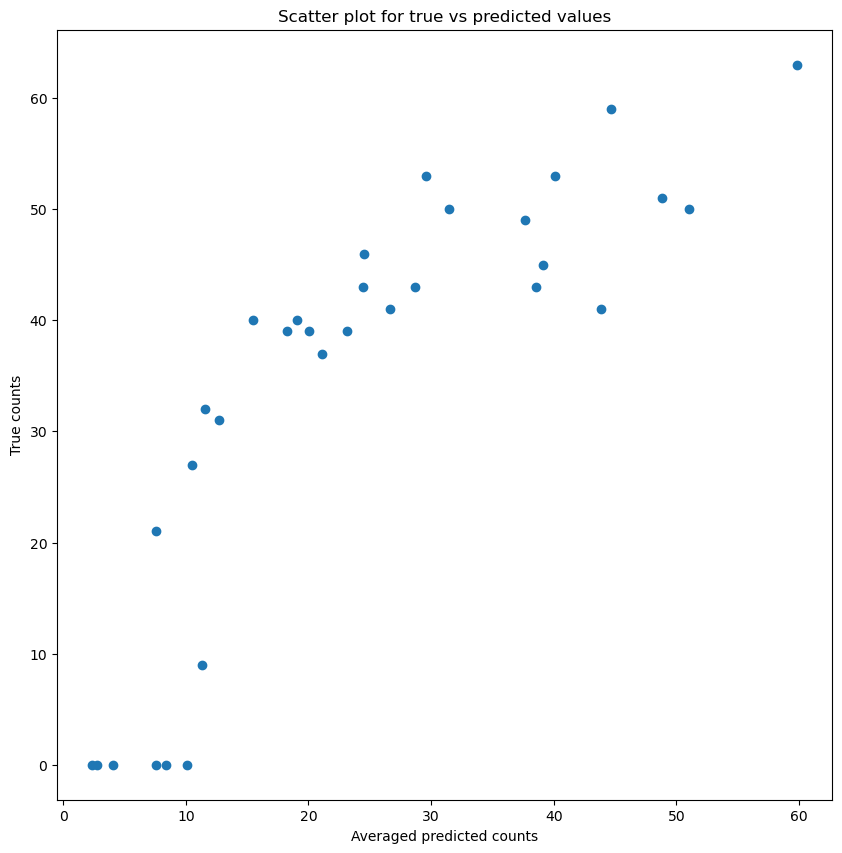

In [61]:
plt.figure(figsize = (10,10))
plt.scatter( averaged_preds, true_counts_df['true_count'])
plt.title("Scatter plot for true vs predicted values")
plt.xlabel("Averaged predicted counts")
plt.ylabel("True counts")
plt.show()

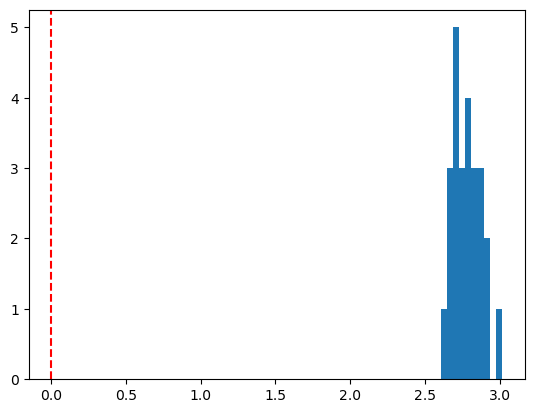

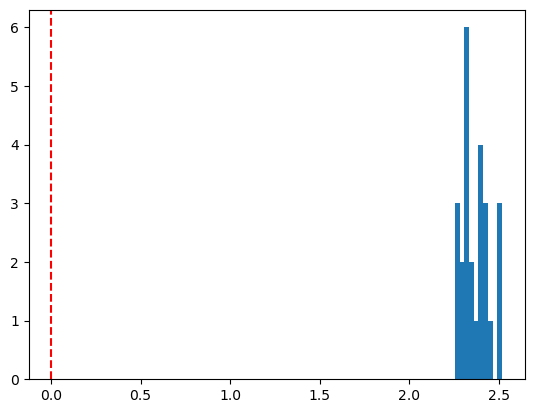

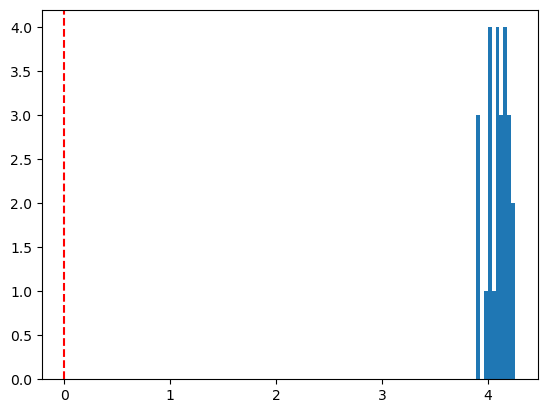

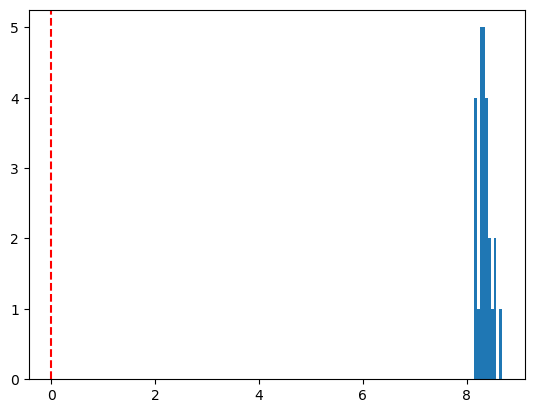

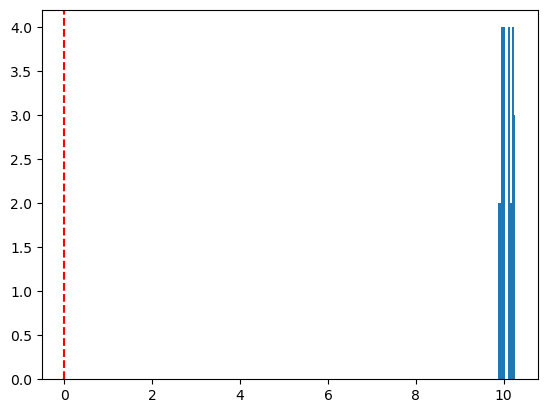

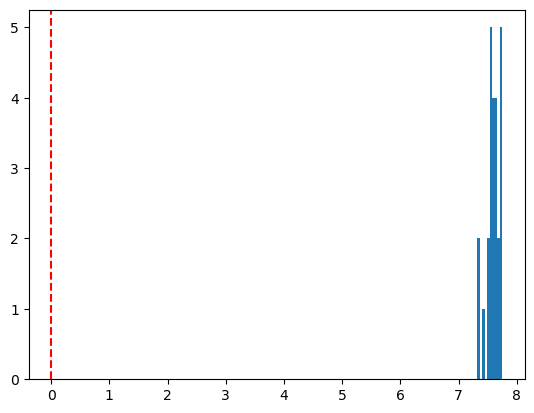

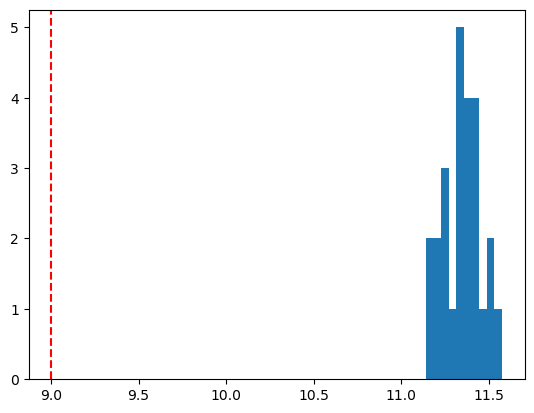

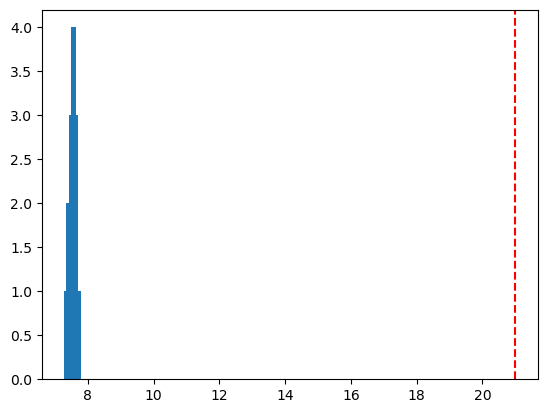

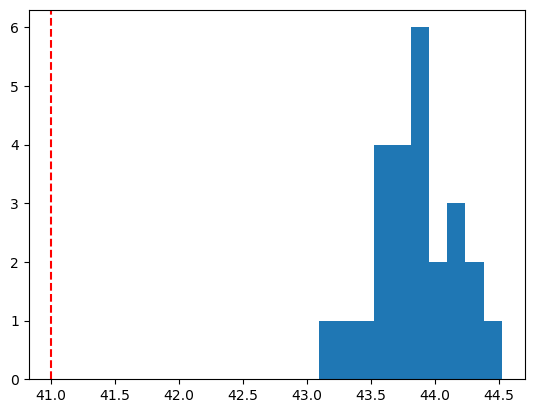

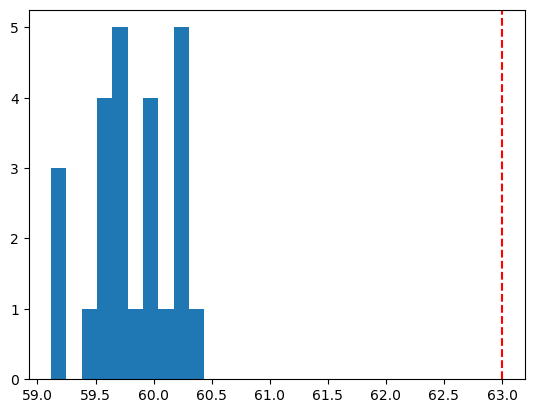

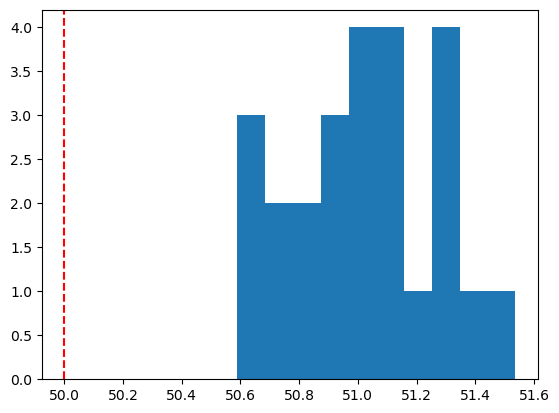

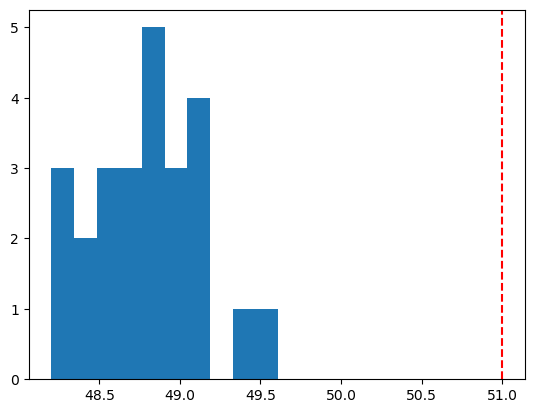

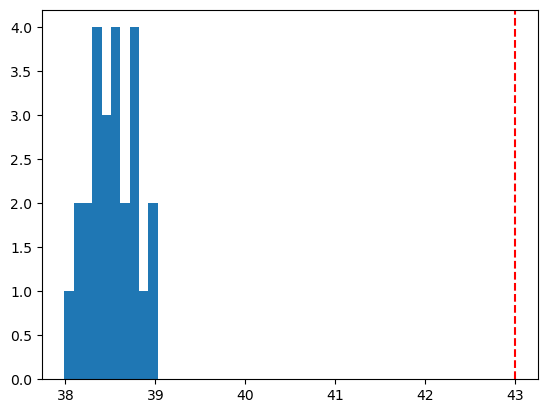

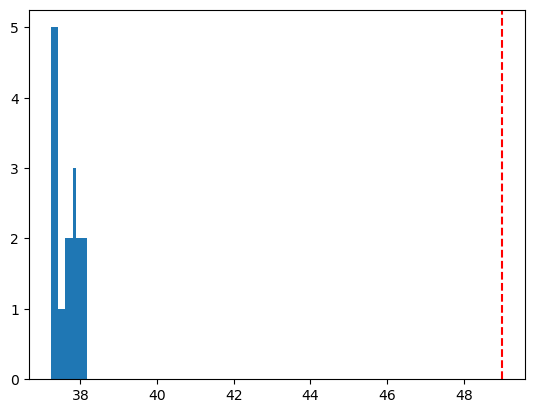

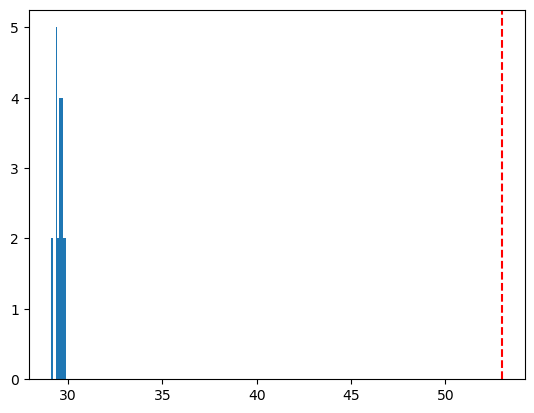

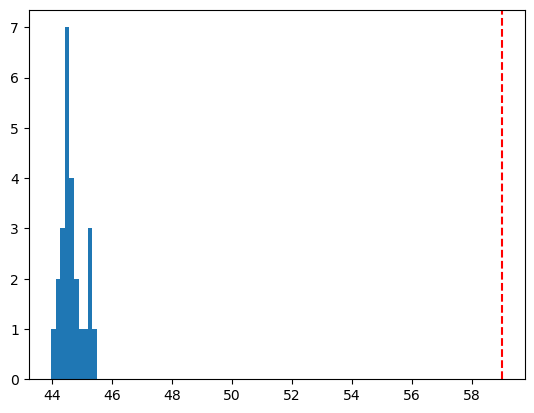

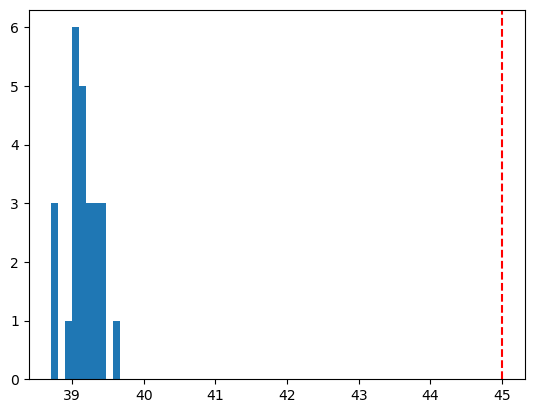

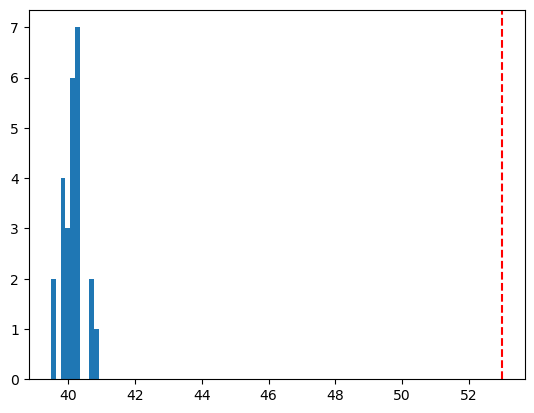

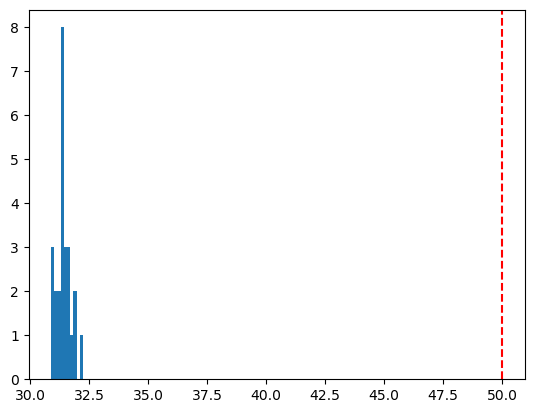

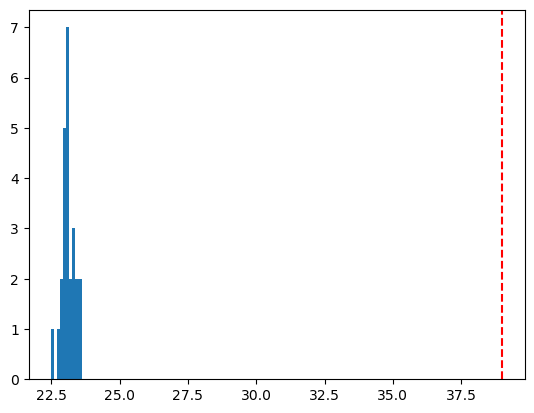

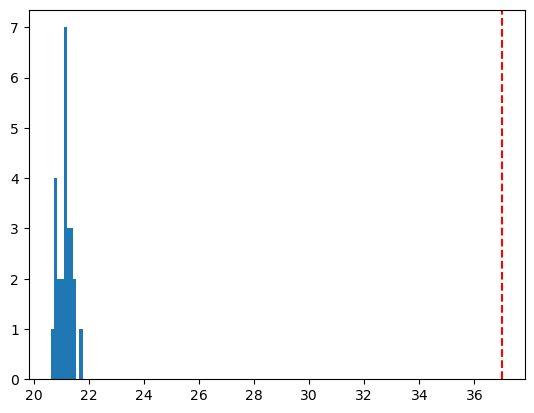

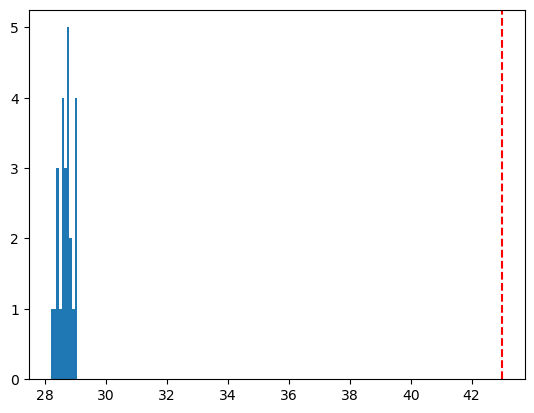

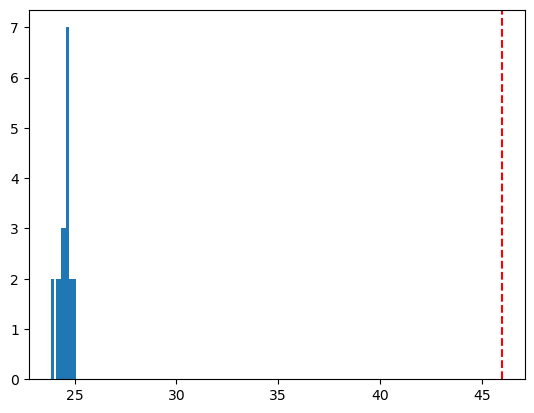

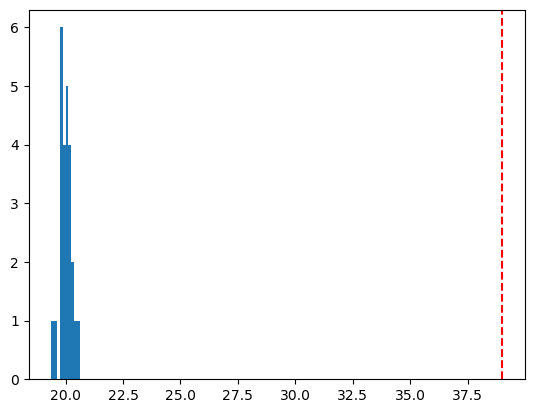

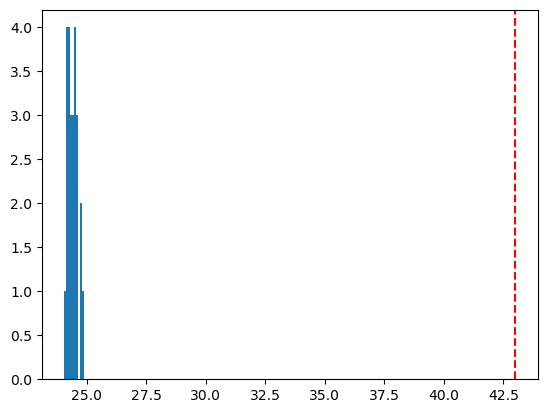

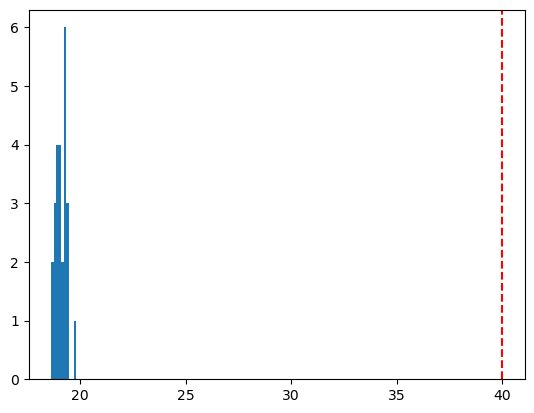

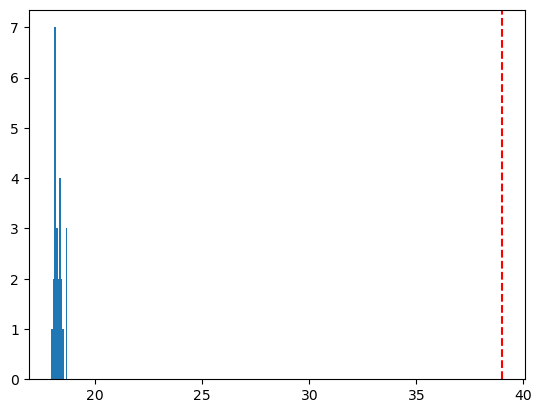

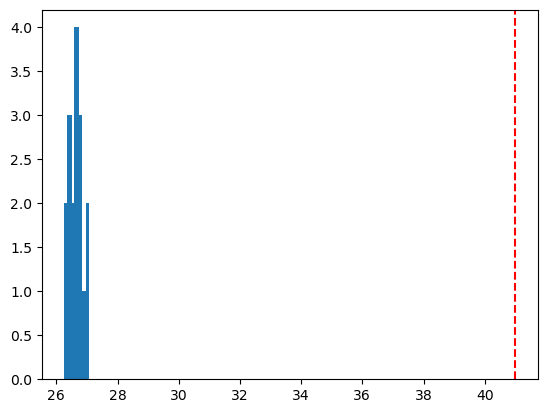

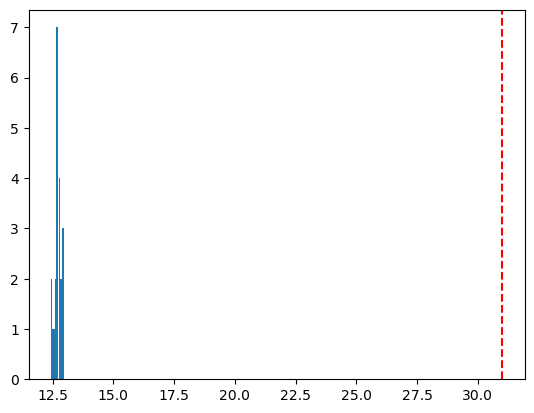

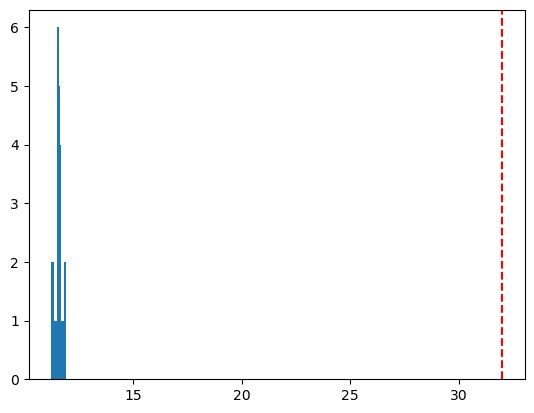

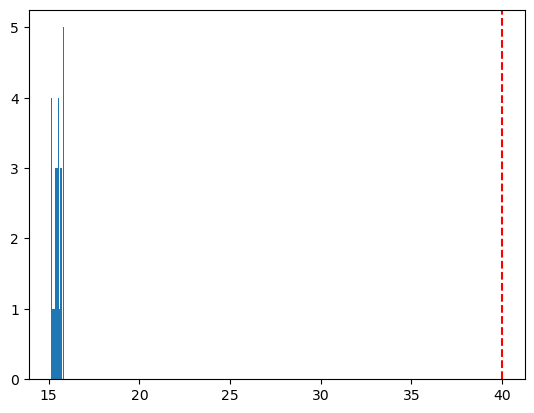

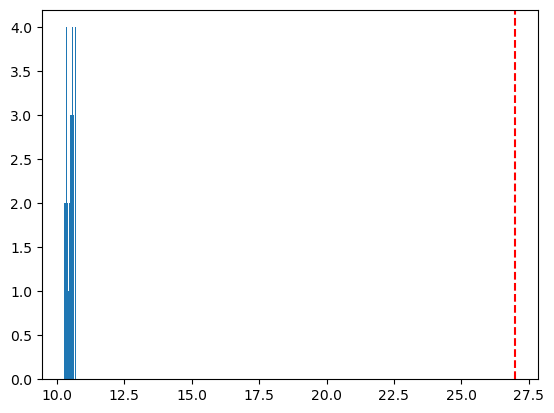

In [62]:
# 06_29
for i in range(joined_df.shape[0]):
    plt.hist(joined_df.iloc[i,2:], bins = 10)
    plt.axvline(x=joined_df.iloc[i,1], color='red', linestyle='--')
    plt.show()